# **Denoising Diffusion Probabilstic Model (DDPM)**

## **Import Dependencies**

In [1]:
import torch
from torchvision import transforms
from torch.utils.data import DataLoader
import torch.nn.functional as F
from torch.optim import AdamW
from diffusers import UNet2DModel, DDPMScheduler, DDPMPipeline
from diffusers.optimization import get_cosine_schedule_with_warmup
from datasets import load_dataset
from accelerate import accelerator, Accelerator
from PIL import Image
from tqdm import tqdm
import numpy as np
import matplotlib.pyplot as plt
import random
import timeit

## **Define Configs**

In [2]:
RANDOM_SEED = 42
IMG_SIZE = 128
BATCH_SIZE = 16
LEARNING_RATE = 1e-4
NUM_EPOCHS = 50
NUM_GENERATE_IMAGES = 9
NUM_TIMESTEPS = 1000
MIXED_PRECISION = 'fp16'
GRADIENT_ACCUMULATION_STEPS = 1

random.seed(RANDOM_SEED)
np.random.seed(RANDOM_SEED)
torch.manual_seed(RANDOM_SEED)
torch.cuda.manual_seed(RANDOM_SEED)
torch.cuda.manual_seed_all(RANDOM_SEED)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

device = 'cuda' if torch.cuda.is_available() else 'cpu'

## **Load Datasets**

In [3]:
# Load the dataset from Hugging Face
dataset = load_dataset('huggan/smithsonian_butterflies_subset', split='train')

Repo card metadata block was not found. Setting CardData to empty.


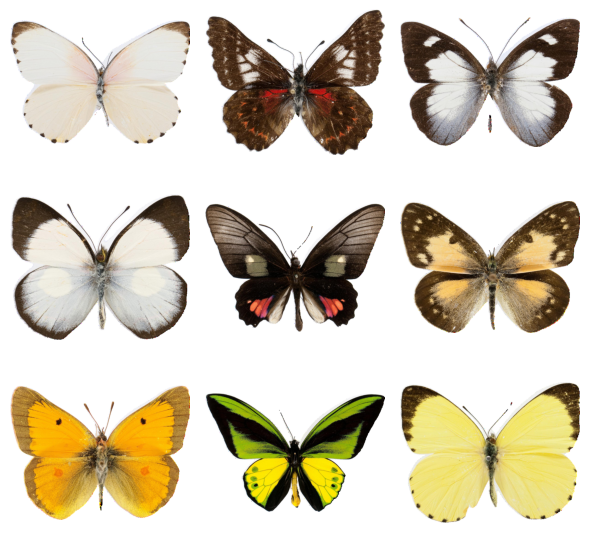

In [4]:
# Plot the data
fig, axes = plt.subplots(ncols=3, nrows=3, figsize=(6, 6))
axes = axes.flatten()

for ax in axes:
    random_id = random.randint(0, len(dataset))
    ax.imshow(dataset[random_id]['image'])
    ax.axis('off')

plt.tight_layout()
plt.show()

## **Data Augmentation**

In [5]:
# Define all the transforms
preprocess = transforms.Compose(
    [
        transforms.Resize((IMG_SIZE, IMG_SIZE)),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize([0.5], [0.5])
    ]
)

# Tranform the images in the dataset
def transform(examples):
    images = [preprocess(image.convert('RGB')) for image in examples['image']]
    return {'images': images}

dataset.set_transform(transform)

## **DataLoader**

In [6]:
# Define the train dataloader
train_dataloader = DataLoader(dataset, batch_size=BATCH_SIZE, shuffle=False)

## **Model**

In [7]:
# Define the model and send it to GPU
model = UNet2DModel(
    sample_size=IMG_SIZE,
    in_channels=3,
    out_channels=3,
    layers_per_block=2,
    block_out_channels=(128, 128, 256, 256, 512, 512),
    down_block_types=(
        'DownBlock2D',
        'DownBlock2D',
        'DownBlock2D',
        'DownBlock2D',
        'AttnDownBlock2D',
        'DownBlock2D'
    ),
    up_block_types=(
        'UpBlock2D',
        'AttnUpBlock2D',
        'UpBlock2D',
        'UpBlock2D',
        'UpBlock2D',
        'UpBlock2D'
    )
)

model = model.to(device)

In [8]:
# Check if the input and output image shapes are same
sample_image = dataset[0]['images'].unsqueeze(0).to(device)
print('Input shape', sample_image.shape)
print('Output shape', model(sample_image, timestep=0).sample.shape)

Input shape torch.Size([1, 3, 128, 128])
Output shape torch.Size([1, 3, 128, 128])


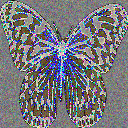

In [9]:
# Noise scheduler
noise_scheduler = DDPMScheduler(num_train_timesteps=NUM_TIMESTEPS)
noise = torch.randn(sample_image.shape).to(device)
timesteps = torch.LongTensor([50]).to(device)
noisy_image = noise_scheduler.add_noise(sample_image, noise, timesteps)

Image.fromarray((
    (noisy_image.permute(0, 2, 3, 1) * 127.5)
    .type(torch.uint8)
    .cpu()
    .numpy()[0]
))

In [10]:
noise_pred = model(noisy_image, timesteps).sample
loss = F.mse_loss(noise_pred, noise)
print(loss)

tensor(1.1955, device='cuda:0', grad_fn=<MseLossBackward0>)


In [11]:
# Function to generate sample images
def sample_image_generation(model, noise_scheduler, num_generate_images, random_seed, num_timesteps):
    pipeline = DDPMPipeline(unet=accelerator.unwrap_model(model), scheduler=noise_scheduler)

    images = pipeline(
        batch_size=num_generate_images,
        generator=torch.manual_seed(random_seed),
        num_inference_steps=num_timesteps
    ).images

    fig, axes = plt.subplots(nrows=3, ncols=3, figsize=(4, 4))
    axes = axes.flatten()

    for i, ax in enumerate(axes):
        ax.imshow(images[i])
        ax.axis('off')

    plt.tight_layout()
    plt.show()

In [12]:
# Define the optimizer
optimizer = AdamW(model.parameters(), lr=LEARNING_RATE)

# Define the learning rate scheduler
lr_scheduler = get_cosine_schedule_with_warmup(
    optimizer=optimizer,
    num_warmup_steps=500,
    num_training_steps=len(train_dataloader) * 50
)

# Initialize HuggingFace Accelerator correctly
accelerator = Accelerator(
    mixed_precision=MIXED_PRECISION,
    gradient_accumulation_steps=GRADIENT_ACCUMULATION_STEPS
)

# Prepare model, optimizer, dataloader, and scheduler for training
model, optimizer, train_dataloader, lr_scheduler = accelerator.prepare(
    model, optimizer, train_dataloader, lr_scheduler
)

## **Training**

100%|██████████| 63/63 [04:18<00:00,  4.10s/it]

------------------------------
Train Loss EPOCH 1: 0.8643
Train Learning Rate EPOCH 1: 1.2600000000000001e-05


  0%|          | 0/1000 [00:00<?, ?it/s]

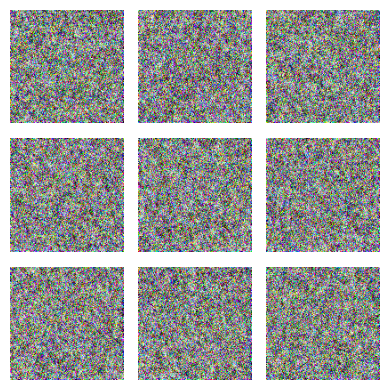

  2%|▏         | 1/50 [06:15<5:06:55, 375.84s/it]

------------------------------


  4%|▍         | 2/50 [10:32<4:04:47, 305.99s/it]

------------------------------
Train Loss EPOCH 2: 0.1621
Train Learning Rate EPOCH 2: 2.5200000000000003e-05
------------------------------


  6%|▌         | 3/50 [14:50<3:42:27, 283.99s/it]

------------------------------
Train Loss EPOCH 3: 0.0749
Train Learning Rate EPOCH 3: 3.7800000000000004e-05
------------------------------


  8%|▊         | 4/50 [19:25<3:35:01, 280.46s/it]

------------------------------
Train Loss EPOCH 4: 0.0614
Train Learning Rate EPOCH 4: 5.0400000000000005e-05
------------------------------


 10%|█         | 5/50 [23:46<3:25:00, 273.35s/it]

------------------------------
Train Loss EPOCH 5: 0.0494
Train Learning Rate EPOCH 5: 6.3e-05
------------------------------


 12%|█▏        | 6/50 [28:05<3:16:52, 268.46s/it]

------------------------------
Train Loss EPOCH 6: 0.0431
Train Learning Rate EPOCH 6: 7.560000000000001e-05
------------------------------


 14%|█▍        | 7/50 [32:23<3:09:58, 265.08s/it]

------------------------------
Train Loss EPOCH 7: 0.0356
Train Learning Rate EPOCH 7: 8.82e-05
------------------------------


 16%|█▌        | 8/50 [36:41<3:03:56, 262.77s/it]

------------------------------
Train Loss EPOCH 8: 0.0314
Train Learning Rate EPOCH 8: 9.999943783063545e-05
------------------------------


 18%|█▊        | 9/50 [40:58<2:58:25, 261.10s/it]

------------------------------
Train Loss EPOCH 9: 0.0280
Train Learning Rate EPOCH 9: 9.984235896746403e-05
------------------------------


 20%|██        | 10/50 [45:16<2:53:16, 259.91s/it]

------------------------------
Train Loss EPOCH 10: 0.0230
Train Learning Rate EPOCH 10: 9.940738186432565e-05
------------------------------


100%|██████████| 63/63 [04:18<00:00,  4.10s/it]

------------------------------
Train Loss EPOCH 11: 0.0230
Train Learning Rate EPOCH 11: 9.869693175497514e-05


  0%|          | 0/1000 [00:00<?, ?it/s]

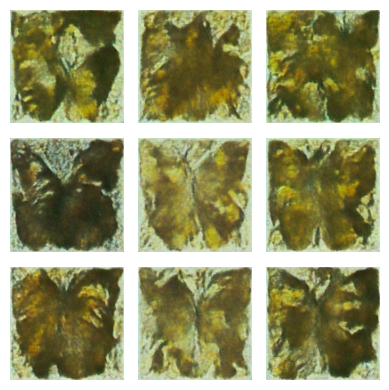

 22%|██▏       | 11/50 [52:04<3:18:30, 305.39s/it]

------------------------------


 24%|██▍       | 12/50 [56:24<3:04:43, 291.68s/it]

------------------------------
Train Loss EPOCH 12: 0.0272
Train Learning Rate EPOCH 12: 9.771496978489323e-05
------------------------------


 26%|██▌       | 13/50 [1:00:44<2:53:49, 281.87s/it]

------------------------------
Train Loss EPOCH 13: 0.0250
Train Learning Rate EPOCH 13: 9.646697092574766e-05
------------------------------


 28%|██▊       | 14/50 [1:05:06<2:45:35, 275.98s/it]

------------------------------
Train Loss EPOCH 14: 0.0251
Train Learning Rate EPOCH 14: 9.495989344945056e-05
------------------------------


 30%|███       | 15/50 [1:09:26<2:38:11, 271.17s/it]

------------------------------
Train Loss EPOCH 15: 0.0227
Train Learning Rate EPOCH 15: 9.320214013201078e-05
------------------------------


 32%|███▏      | 16/50 [1:13:47<2:31:55, 268.11s/it]

------------------------------
Train Loss EPOCH 16: 0.0227
Train Learning Rate EPOCH 16: 9.120351140349089e-05
------------------------------


 34%|███▍      | 17/50 [1:18:08<2:26:10, 265.78s/it]

------------------------------
Train Loss EPOCH 17: 0.0206
Train Learning Rate EPOCH 17: 8.897515070528305e-05
------------------------------


 36%|███▌      | 18/50 [1:22:29<2:21:02, 264.45s/it]

------------------------------
Train Loss EPOCH 18: 0.0199
Train Learning Rate EPOCH 18: 8.652948235936705e-05
------------------------------


 38%|███▊      | 19/50 [1:26:47<2:15:43, 262.70s/it]

------------------------------
Train Loss EPOCH 19: 0.0188
Train Learning Rate EPOCH 19: 8.388014229596275e-05
------------------------------


 40%|████      | 20/50 [1:31:07<2:10:50, 261.69s/it]

------------------------------
Train Loss EPOCH 20: 0.0161
Train Learning Rate EPOCH 20: 8.104190202580812e-05
------------------------------


100%|██████████| 63/63 [04:21<00:00,  4.15s/it]

------------------------------
Train Loss EPOCH 21: 0.0174
Train Learning Rate EPOCH 21: 7.803058628095877e-05


  0%|          | 0/1000 [00:00<?, ?it/s]

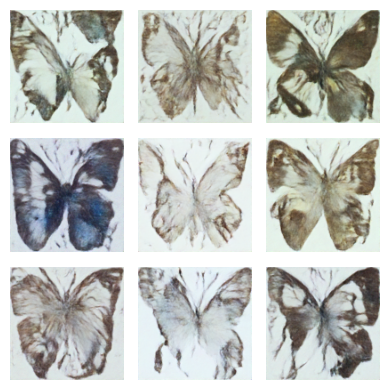

 42%|████▏     | 21/50 [1:37:58<2:28:14, 306.71s/it]

------------------------------


 44%|████▍     | 22/50 [1:42:16<2:16:10, 291.81s/it]

------------------------------
Train Loss EPOCH 22: 0.0215
Train Learning Rate EPOCH 22: 7.486298478330615e-05
------------------------------


 46%|████▌     | 23/50 [1:46:30<2:06:19, 280.73s/it]

------------------------------
Train Loss EPOCH 23: 0.0195
Train Learning Rate EPOCH 23: 7.155675863275306e-05
------------------------------


 48%|████▊     | 24/50 [1:50:50<1:58:55, 274.45s/it]

------------------------------
Train Loss EPOCH 24: 0.0200
Train Learning Rate EPOCH 24: 6.813034183698301e-05
------------------------------


 50%|█████     | 25/50 [1:55:11<1:52:37, 270.30s/it]

------------------------------
Train Loss EPOCH 25: 0.0190
Train Learning Rate EPOCH 25: 6.460283853184879e-05
------------------------------


 52%|█████▏    | 26/50 [1:59:32<1:46:59, 267.48s/it]

------------------------------
Train Loss EPOCH 26: 0.0191
Train Learning Rate EPOCH 26: 6.0993916465432213e-05
------------------------------


 54%|█████▍    | 27/50 [2:03:51<1:41:32, 264.90s/it]

------------------------------
Train Loss EPOCH 27: 0.0178
Train Learning Rate EPOCH 27: 5.732369733965931e-05
------------------------------


 56%|█████▌    | 28/50 [2:08:11<1:36:35, 263.43s/it]

------------------------------
Train Loss EPOCH 28: 0.0173
Train Learning Rate EPOCH 28: 5.361264462087627e-05
------------------------------


 58%|█████▊    | 29/50 [2:12:30<1:31:45, 262.15s/it]

------------------------------
Train Loss EPOCH 29: 0.0165
Train Learning Rate EPOCH 29: 4.9881449444902904e-05
------------------------------


 60%|██████    | 30/50 [2:16:47<1:26:55, 260.78s/it]

------------------------------
Train Loss EPOCH 30: 0.0142
Train Learning Rate EPOCH 30: 4.615091525270501e-05
------------------------------


100%|██████████| 63/63 [04:17<00:00,  4.09s/it]

------------------------------
Train Loss EPOCH 31: 0.0151
Train Learning Rate EPOCH 31: 4.244184179990459e-05


  0%|          | 0/1000 [00:00<?, ?it/s]

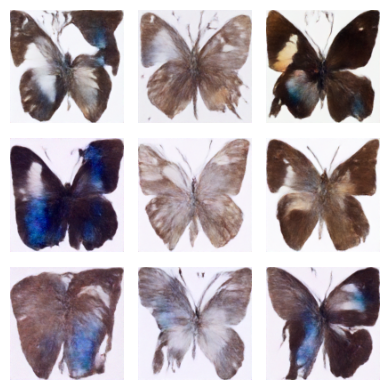

 62%|██████▏   | 31/50 [2:23:36<1:36:35, 305.00s/it]

------------------------------


 64%|██████▍   | 32/50 [2:27:51<1:27:04, 290.23s/it]

------------------------------
Train Loss EPOCH 32: 0.0186
Train Learning Rate EPOCH 32: 3.87749091868379e-05
------------------------------


 66%|██████▌   | 33/50 [2:32:09<1:19:30, 280.59s/it]

------------------------------
Train Loss EPOCH 33: 0.0174
Train Learning Rate EPOCH 33: 3.517056255575659e-05
------------------------------


 68%|██████▊   | 34/50 [2:36:25<1:12:48, 273.04s/it]

------------------------------
Train Loss EPOCH 34: 0.0181
Train Learning Rate EPOCH 34: 3.164889809804808e-05
------------------------------


 70%|███████   | 35/50 [2:40:40<1:06:53, 267.59s/it]

------------------------------
Train Loss EPOCH 35: 0.0171
Train Learning Rate EPOCH 35: 2.822955100704634e-05
------------------------------


 72%|███████▏  | 36/50 [2:44:59<1:01:50, 265.07s/it]

------------------------------
Train Loss EPOCH 36: 0.0169
Train Learning Rate EPOCH 36: 2.4931586001157835e-05
------------------------------


 74%|███████▍  | 37/50 [2:49:15<56:52, 262.48s/it]  

------------------------------
Train Loss EPOCH 37: 0.0162
Train Learning Rate EPOCH 37: 2.1773391027694734e-05
------------------------------


 76%|███████▌  | 38/50 [2:53:32<52:08, 260.72s/it]

------------------------------
Train Loss EPOCH 38: 0.0159
Train Learning Rate EPOCH 38: 1.8772574740075105e-05
------------------------------


 78%|███████▊  | 39/50 [2:57:52<47:46, 260.56s/it]

------------------------------
Train Loss EPOCH 39: 0.0153
Train Learning Rate EPOCH 39: 1.5945868320010076e-05
------------------------------


 80%|████████  | 40/50 [3:02:14<43:28, 260.81s/it]

------------------------------
Train Loss EPOCH 40: 0.0132
Train Learning Rate EPOCH 40: 1.3309032192072463e-05
------------------------------


100%|██████████| 63/63 [04:20<00:00,  4.14s/it]

------------------------------
Train Loss EPOCH 41: 0.0140
Train Learning Rate EPOCH 41: 1.0876768150764277e-05


  0%|          | 0/1000 [00:00<?, ?it/s]

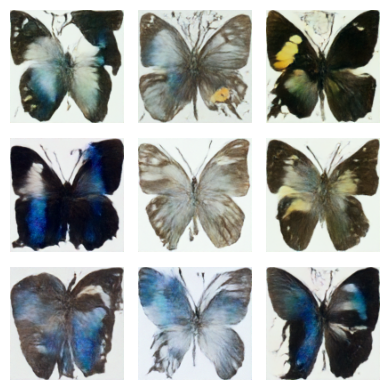

 82%|████████▏ | 41/50 [3:09:05<45:52, 305.85s/it]

------------------------------


 84%|████████▍ | 42/50 [3:13:20<38:46, 290.83s/it]

------------------------------
Train Loss EPOCH 42: 0.0173
Train Learning Rate EPOCH 42: 8.66263739002211e-06
------------------------------


 86%|████████▌ | 43/50 [3:17:35<32:40, 280.11s/it]

------------------------------
Train Loss EPOCH 43: 0.0163
Train Learning Rate EPOCH 43: 6.678984892190559e-06
------------------------------


 88%|████████▊ | 44/50 [3:21:54<27:21, 273.61s/it]

------------------------------
Train Loss EPOCH 44: 0.0170
Train Learning Rate EPOCH 44: 4.9368705980363415e-06
------------------------------


 90%|█████████ | 45/50 [3:26:13<22:25, 269.15s/it]

------------------------------
Train Loss EPOCH 45: 0.0162
Train Learning Rate EPOCH 45: 3.4460077415675474e-06
------------------------------


 92%|█████████▏| 46/50 [3:30:30<17:43, 265.78s/it]

------------------------------
Train Loss EPOCH 46: 0.0158
Train Learning Rate EPOCH 46: 2.214708693475065e-06
------------------------------


 94%|█████████▍| 47/50 [3:34:45<13:07, 262.50s/it]

------------------------------
Train Loss EPOCH 47: 0.0155
Train Learning Rate EPOCH 47: 1.2498386151482467e-06
------------------------------


 96%|█████████▌| 48/50 [3:39:01<08:40, 260.32s/it]

------------------------------
Train Loss EPOCH 48: 0.0152
Train Learning Rate EPOCH 48: 5.567771816690381e-07
------------------------------


 98%|█████████▊| 49/50 [3:43:16<04:18, 258.91s/it]

------------------------------
Train Loss EPOCH 49: 0.0147
Train Learning Rate EPOCH 49: 1.3938858719967363e-07
------------------------------


100%|██████████| 50/50 [3:47:33<00:00, 273.06s/it]

------------------------------
Train Loss EPOCH 50: 0.0127
Train Learning Rate EPOCH 50: 0.0
------------------------------
Training Time: 13653.19s


In [13]:
# Training process
start = timeit.default_timer()
for epoch in tqdm(range(NUM_EPOCHS), position=0, leave=True):
    model.train()
    train_running_loss = 0
    for idx, batch in enumerate(tqdm(train_dataloader, position=0, leave=True)):
        clean_images = batch['images'].to(device)
        noise = torch.randn(clean_images.shape).to(device)
        last_batch_size = len(clean_images)

        timesteps = torch.randint(0, noise_scheduler.config.num_train_timesteps, (last_batch_size, )).to(device)
        noisy_images = noise_scheduler.add_noise(clean_images, noise, timesteps)

        with accelerator.accumulate(model):
            noise_pred = model(noisy_images, timesteps, return_dict=False)[0]
            loss = F.mse_loss(noise_pred, noise)
            accelerator.backward(loss)

            accelerator.clip_grad_norm_(model.parameters(), 1.0)
            optimizer.step()
            lr_scheduler.step()
            optimizer.zero_grad()

        train_running_loss += loss.item()

    train_loss = train_running_loss / (idx + 1)
    train_learning_rate = lr_scheduler.get_last_lr()[0]

    print('-'*30)
    print(f'Train Loss EPOCH {epoch+1}: {train_loss:.4f}')
    print(f'Train Learning Rate EPOCH {epoch+1}: {train_learning_rate}')
    
    if epoch % 10 == 0:
        sample_image_generation(model, noise_scheduler, NUM_GENERATE_IMAGES, RANDOM_SEED, NUM_TIMESTEPS)
    print('-'*30)

stop = timeit.default_timer()
print(f'Training Time: {stop - start:.2f}s')


  0%|          | 0/1000 [00:00<?, ?it/s]

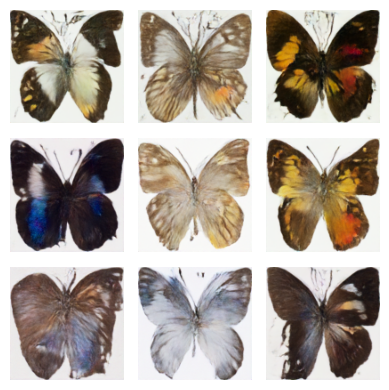

In [14]:
sample_image_generation(
    model=model,
    noise_scheduler=noise_scheduler,
    num_generate_images=NUM_GENERATE_IMAGES,
    random_seed=RANDOM_SEED, 
    num_timesteps=NUM_TIMESTEPS
)

In [16]:
# Save the model
# torch.save(model.state_dict(), 'model_weights.pth')